In [1]:
with open("video_7_dependencies/input.txt", "r", encoding = "utf-8") as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
#Let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [7]:
text[0]

'F'

In [8]:
#All unique char occur in text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


Tokenize: Convert RAW string represenation to some sequence of integers according to some vocabulary


Here we are building a character-level language model

In [173]:
#create a mapping from chars to ints
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i: ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] #Func for string to list of int
decode = lambda l: "".join([itos[i] for i in l]) #Func for list of int to string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Will have trade off between vocab size and sequence sizes, where the larger the vocab, the fewer amount of integers needed to represent single words, wheras with a smaller vocab size, will need more ints to represent single words

In [10]:
#Encode the entire text dataset and store in torch.Tensor

import torch
data = torch.tensor(encode(text), dtype = torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [11]:
#Split up the data into train and validation sets

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [12]:
block_size = 8 #maximum length 
train_data[:block_size+1]

#There are actually 8 "training examples in this sequence of 9 chars", given 18 predict 47, given 18,47 predict 56

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [13]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target {target}")

when input is tensor([18]) the target 47
when input is tensor([18, 47]) the target 56
when input is tensor([18, 47, 56]) the target 57
when input is tensor([18, 47, 56, 57]) the target 58
when input is tensor([18, 47, 56, 57, 58]) the target 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target 58


We train on all the examples here, with context between 1 and block_size, not only for effiencany, but also to allow for the NN to be used to seeing context as little as 1 to all the way to block_size

After block_size amount of context, need to start truncating, as the transformer will never recieve more then block_size inputs when it is predicting the next char

In [45]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


In [46]:
#Incorporating batch dimension (GPU's really good at parallelization)

torch.manual_seed(1337)
batch_size = 4 #How many independent sequences will we process in parallel?
block_size = 8 #What is the maximum context length for predictions?

def get_batch(split):
    #generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) #Stack will "stack" rows
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch("train")
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

print("----")
for b in range(batch_size): #batch dim
    for t in range(block_size): #time dim
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='mps:0')
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='mps:0')
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the 

In [15]:
print(xb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [56]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        #Each token will return vocab_size tensor, where each logit i can be interpreted as unnormalized probability of the next token being i (i.e logit 24 corresonds to integer 24 being the next predicted token)
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets = None):
        logits = self.token_embedding_table(idx) # (B, T, C)
        if targets is None:
            loss = None
        else:
        #Option 1:
        # loss = F.cross_entropy(logits.permute(0, 2, 1), targets) #Cross entropy needs (B, Class, d1 ...)

        #Karpathy Option 2, create 2-dim array:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            #get the predictions
            logits, loss = self(idx)
            #Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            #apply softmax to get probabilities
            probs = F.softmax(logits, dim = -1) #(B, C)
            #sample from dist.
            idx_next = torch.multinomial(probs, num_samples = 1) #(B, 1)
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
        return idx
    
m = BigramLanguageModel(vocab_size)
m = m.to(device)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
#torch.zeros((1,1), dtype = torch.long kicks off the generation
print(decode(m.generate(torch.zeros((1,1), dtype = torch.long, device = device), max_new_tokens = 100)[0].tolist()))

torch.Size([256, 65])
tensor(4.7783, device='mps:0', grad_fn=<NllLossBackward0>)

UNasE3QKdYMjKfxcq-PyQbRF.
jxuUfZWievNL:C&v-jkcECOIiyeg zbZAcQ?yObr&MkzeAmyFXSPHd,j&?oneOAvrFotKuLTDx


Note: In the above BiGram model, there is no context be used; each char is used independently to predict the next char

In [57]:
#Random Loss
print(-torch.log(torch.tensor(1/65)))

tensor(4.1744)


In [58]:
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

In [59]:
max_iters = 3000
eval_iters = 200
eval_interval = 300

In [60]:
#Function to have less noisy estimates of loss

@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval() #set model to evaluation phase (important from batchnorm, dropout etc ...)
    for split in ["train", "val"]:
        #averages the loss over multiple batches
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()  #set model to train phase
    return out

In [61]:
batch_size = 32
for iter in range(max_iters):

    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch("train")

    logits, loss = m(xb, yb)

    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()

print(loss.item())

step 0: train loss 4.7305, val loss 4.7241
step 300: train loss 4.3818, val loss 4.3896
step 600: train loss 4.0801, val loss 4.0784
step 900: train loss 3.8066, val loss 3.8117
step 1200: train loss 3.5844, val loss 3.5850
step 1500: train loss 3.3757, val loss 3.3829
step 1800: train loss 3.2182, val loss 3.2218
step 2100: train loss 3.0817, val loss 3.0810
step 2400: train loss 2.9663, val loss 2.9739
step 2700: train loss 2.8809, val loss 2.8800
2.794020175933838


In [62]:
print(decode(m.generate(torch.zeros((1,1), dtype = torch.long, device = device), max_new_tokens = 100)[0].tolist()))


&Pay boin ppry way av IF$EZbT:$zDusickns bokthaNAl-hiNCL:

p, ?w elgne? gwise f, -lbustselow!'dcus; 


The mathematical trick in self-attention

In [63]:
#Consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 #batch, time, channels
x = torch.randn(B,T,C)
x.shape

#We want tokens in the Tth location to only interact with tokens in the Tth - 1 to 0 location, not to any in 
#a location > Tth (such that information only flows from previous context to current time step)



torch.Size([4, 8, 2])

In [91]:
#Attempt 1 to incorporate context: Average previous Tth - 1 to 0 information with Tth token
#Problem: Quite lossy, as lose alot of information w.r.t to spatial arrangement

#We want x[b,t] = mean_(i<=t) x[b, i]

xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1,:] # (t, C)
        xbow[b, t] = torch.mean(xprev, 0)


In [68]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [69]:
xbow[0]
#Can see if first location, equivalent, since no prior context
#But in position 2, XBOW is average of position 1 and 2
#And so on

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [70]:
#But the above is very ineffeciant, we can use matrix multiplication to improve effic.

In [72]:
torch.manual_seed(42)
a = torch.ones(3,3)
b = torch.randint(0, 10, (3,2)).float()

print(a)
print(b)

c = a @ b
print(c)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [74]:
torch.tril(torch.ones(3,3)) #returns lower triangle portion

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [76]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
b = torch.randint(0, 10, (3,2)).float()

print(a)
print(b)

c = a @ b
print(c)

#We can see with C, we are getting a cumulative sum of B, for each column of B

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [78]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a/torch.sum(a, dim = 1, keepdim = True)
b = torch.randint(0, 10, (3,2)).float()

print(a)
print(b)

c = a @ b
print(c)

#Now we have an incremental weighted sum of B

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [94]:
#Creating a more efficient approach to computing XBOW (equal weighted aggregation using only previous time steps and itself)


print(x.shape)
wei = torch.tril(torch.ones((T,T)))
wei = wei/torch.sum(a, 1, keepdim=True)
print(wei.shape)
xbow2 = (a @ x) 
#(T,T) @ (B,T,C) -> Torch will create a Batch Dim -> (B,T,T) @ (B,T,C) -> Will now a batched Matrix Multiply: Will apply all these matrix multiplications in batches in parallel
#Such that for each batch element there will be a TT @ TC
print(xbow2.shape)

torch.Size([4, 8, 2])
torch.Size([8, 8])
torch.Size([4, 8, 2])


In [96]:
torch.allclose(xbow, xbow2)

True

In [99]:
#Version 3, using softmax

tril = torch.tril(torch.ones((T,T)))
wei = torch.zeros((T,T)) #While we have set these to 0's, these are weights/affinities which through training will be altered to represent strong or weak relationships between tokens; in a data-dependent manner
wei = wei.masked_fill(tril == 0, float("-inf")) #set to -inf any where tril == 0 ; ensures future tokens cannot communicate with the past
print(wei)
wei = F.softmax(wei, dim = -1) #e^-inf = 0, where as e^0 = 1; softmax computes e_i/(sum of e_0 to e_n) for all e; so basically computes weighted sum
print(wei)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [113]:
#version  4: self-attention: allows for nodes/elements/tokens to gather information in the past in a data-dependent manner (i.e element at time T is not just an average of all past represenations and itself, instead the element at time T could be a vowel and place increased emphasis on prior incidences of consonant)

torch.manual_seed(1337)
B,T,C = 4,8,32 #batch, time, channels/embedding_dim
x = torch.randn(B,T,C)

#Every single token/node at each position will emit two vectors, a query and key
#query: query vector corresponds to: "what am I looking for"
#key: key vector corresponds to: "what do I contain"
#The way we get affinities between these tokens in a sequence is to do dot product between keys and queries
#If they query of one token in a sequence is aligned higly with a key of another token in the sequence, will interact to a very high amount, and will get to learn more about that specific token as opposed to any other token in the sequence

#let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias = False)
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias = False)
k = key(x) #B, T, head_size
q = query(x) #B, T, head_size
v = value(x)
wei = q @ torch.transpose(k,-2,-1) # (B, T, 16) @ (B, 16, T) --> (B,T,T)


tril = torch.tril(torch.ones(T,T)) #Mask needed to prevent elements/tokens from aggregating information from later time steps
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim = -1)

out = wei @ v #Dont aggregate raw vectors, aggregate transformed "value" vectors 

print(out.shape)
#Intuitative:
#8th token, knows what content it has and the position it is in (via embeddings), then create a query (using nn.Linear) which
#could emit "I am looking for specific stuff, such as I am a vowel at 8th position and I am lookinng for consonants at any position up to 4"
#The all the nodes needs to emit keys, and maybe one of the channels could be I am a constantant and I am at a position up to 4.
#This key would have a high number in this channel, and so when query and key dot product, they can find each other and have a high affinity
#Then through softmax will end up aggregating alot of its information into my position

#Summary: Can now determine in a data-dependent manner, how much to aggregate from each token in the past

torch.Size([4, 8, 16])


In [109]:
wei
#Notice, this differs across batches, since each batch (which corresponds to a sequence) is composed of a different set of tokens

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

Attention is a communication mechanism, where you have N number of nodes in a directed graph, where you have edges pointed between them. Every node has a vector of information, and it gets to aggregrate information via weighted sum of all the nodes which point to it; done in a data-dependent manner.

In an autoregressive language model context, such as this where there are 8 nodes (i.e blocksize = 8), the first node is pointed to by itself. The second node is pointed to by itself and the first node. The third node pointed to by itself, second, and first etc...

This is how our directed graph looks like, but in principle attention can be applied to any arbitrary directed graph, and is just a communication mechanism between nodes

Attention has no notion of space, simply acts over a set of vectors. This is why positional encoding is needed

While we have constrained it such that a token at time T cannot communicate with future tokens, this does not always have to be the case. In problems such as Sentiment Analysis, might want to allow for all tokens to communicate with each other, because later you are predicting the sentiment of a sentence. In this instance, you would use an encoder block of self-attention. All this means is you would remove torch.tril(), allowing all nodes to talk with each other. What we are implementing here is a decoder block

We call this attention self-attention, since keys, queries, and values are from the same source X. Cross-Attention is when keys,values come from a differnt source which we would like to pool information from that which is used to produce the queries

In [131]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2,-1) *head_size**-0.5

In [130]:
#If k and q unit guassian, we find that wei's variance will be  on the order of head_size (=16)
k.var(), q.var(), wei.var()

(tensor(1.0652), tensor(0.9575), tensor(14.6189))

In [132]:
#But if we divide by square root of head_size, wei's variance will be 1
#This is important because at init, because wei feeds into softmax, we want wei to be fairly diffuse
#If we dont use this, and allow for wei to have very pos and neg numbers, softmax will converge to one-hot vectors (as seen when scaling the inputs to softmax below)
#This will in turn make it too peaky such that each node will in a sense aggregate information from only one other node; which is not what we want; esp at init
k.var(), q.var(), wei.var(), torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim = -1), torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim = -1)


(tensor(0.9279),
 tensor(0.9473),
 tensor(0.9156),
 tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872]),
 tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000]))

Create self-attention head

In [135]:
n_embd = 32

In [163]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias = False)
        self.query = nn.Linear(n_embd, head_size, bias = False)
        self.value = nn.Linear(n_embd, head_size, bias = False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        #Since tril is not a parameter of the model, in pytorch convention it is a buffer; so need register_buffer to assign it to module
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) #b,t,head_size
        q = self.query(x) #b,t,head_size

        #compute attention scores
        wei = q @ k.transpose(-2,-1) * C**-0.5 #b,t,t
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # b,t,t
        wei = F.softmax(wei, dim = -1) #b,t,t
        wei = self.dropout(wei)

        #perform weighted aggregation of values
        v = self.value(x)
        out = wei @ v #b,t,head_size
        return out

In actuality, we use multiple self-attention blocks in parallel and concatenate: multi-head attention

It helps to use multiple self-attention heads (multiple communication channels), since these tokens have a lot to talk about (i.e want to find vowels, want to find consonants , want to find them in certain positions etc...); there useful to create multiple heads, gather multiple differnt types of data and decode the output

In [164]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size)for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out)
        return out

In [165]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embd, 4*n_embd), nn.ReLU(), nn.Linear(4*n_embd, n_embd), nn.Dropout(0.3)) #need projection layer to get back n_embd to allow for it to get back into the residual pathway

    def forward(self, x):
        return self.net(x)
    

#Above is useful to add after multi-head attention, to give an oppurtunity after the tokens have looked at each
#other, to "think on what they found from other tokens"

#Note: This is being applied on a per-token level, all the tokens do this independetly. So the self-attention is the communication, and once thety have gathhered
#all the data, they need to think on that data individually

In [157]:
class Block(nn.Module):
    """ Transformer block: Intersperse communication (multi-head SA) followed by computation (FFwd) """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

However, simply using a bunch of these blocks will not work. Since our NN is becoming pretty deep, it will run into some optimization issues. 

One important component to incorporate in this network is skip connections/residual connections
- Add transformed data to original input data. Ex. X = F(X) + X, where F could be FeedFoward()

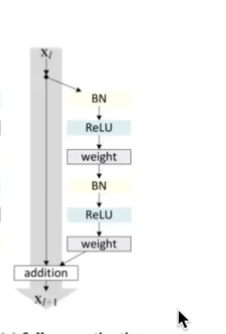

Remembering that addition distributes the gradients equally, it creates a gradient superhighway all the way from the loss/supervision all the way to the input unimpeded. These residual blocks are often initialized at the beginning such that they contribute very little to the residual pathway (almost like not there). Overtime, through training, they do start to contribute

This dramatically helps with optimization

In [158]:
class Block(nn.Module):
    """ Transformer block: Intersperse communication (multi-head SA) followed by computation (FFwd) """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size) 
        self.ffwd = FeedForward(n_embd) 

    def forward(self, x):
        x = x + self.sa(x) #b,t,n_embd
        x = x + self.ffwd(x) #b,t,n_embd

        #Added some extra computation to self.sa and self.ffwd to grow the size of layer in residual block on the side of the residual pathway
        return x
    

Another important innovation for optimizing really deep NN, is incorporating LayerNorm

Unlike BatchNorm, in which we normalize the columns, instead we normalize the rows

#xmean(0, keepdim = True) in batchnorm is instead xmean(1, keepdim = True)
#xvar(0, keepdim = True) in batchnorm is instead xvar(1, keepdim = True)

But since the computation does not span across examples in a batch, we can delete all the running mean and var buffers; and no distinction between training and test time; momentum

All we retain is gamma and beta from batchnorm



In [ ]:
class Block(nn.Module):
    """ Transformer block: Intersperse communication (multi-head SA) followed by computation (FFwd) """

    #Layernorms are applied immediately before fed to MSA and FFwd
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size) 
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd) #The mean and variance are taken over 32(n_embd) numbers, so both and b,t function as batch dimensions; so a per-token transformation that norms. the features and makes them unit mean and guasssian at init
        self.ln2 = nn.LayerNorm(n_embd) #the gamma and beta allow for layernorm to eventually generate outputs that are not unit guassian; but optimization will determine that

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) #b,t,n_embd
        x = x + self.ffwd(self.ln2(x)) #b,t,n_embd

        #Added some extra computation to self.sa and self.ffwd to grow the size of layer in residual block on the side of the residual pathway
        return x

We also added dropout, which every forward and backward pass randomly shuts off some subset of neurons (makes them 0) and trains without them. Because the mask of what is dropped out changes every forward and backward pass, it ends up training an ensemble of subnetworks

At evaluation, all neurons are enables, and it ends up merging these subnetworks into a single ensemble

It is a regularization technique used to deal with overfitting

Below is a basic Transformer Architecture

In [166]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # self.sa_head = MultiHeadAttention(4, n_embd//4) # i.e 4 heads of 8-dimensional self-attention, 4x8 = 32, can run nicely in the next layer which expects input to have n_embd dims
        # self.ffwd = FeedForward(n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head = 4),
            Block(n_embd, n_head = 4),
            Block(n_embd, n_head = 4),
            nn.LayerNorm(n_embd),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets = None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T, n_embd), create embeddings for all positions
        x = tok_emb + pos_emb
        # x = self.sa_head(x) #apply multi-head self-attention (B,T,n_embd)
        # x = self.ffwd(x) #(B,T,n_embd)
        x = self.blocks(x) #(B,T,n_embd)
        logits = self.lm_head(x) #(B, T, C)
        if targets is None:
            loss = None
        else:
        #Option 1:
        # loss = F.cross_entropy(logits.permute(0, 2, 1), targets) #Cross entropy needs (B, Class, d1 ...)

        #Karpathy Option 2, create 2-dim array:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens: needed so that positional embeddings do not get out of scope
            idx_cond = idx[:, -block_size:]
            #get the predictions
            logits, loss = self(idx_cond)
            #Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            #apply softmax to get probabilities
            probs = F.softmax(logits, dim = -1) #(B, C)
            #sample from dist.
            idx_next = torch.multinomial(probs, num_samples = 1) #(B, 1)
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
        return idx

In [167]:
m = BigramLanguageModel(vocab_size)
m = m.to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

batch_size = 32
for iter in range(max_iters):

    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch("train")

    logits, loss = m(xb, yb)

    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.4119, val loss 4.4191
step 300: train loss 2.5852, val loss 2.5897
step 600: train loss 2.4304, val loss 2.4240
step 900: train loss 2.3571, val loss 2.3576
step 1200: train loss 2.3021, val loss 2.3183
step 1500: train loss 2.2658, val loss 2.2785
step 1800: train loss 2.2245, val loss 2.2390
step 2100: train loss 2.2155, val loss 2.2290
step 2400: train loss 2.1927, val loss 2.2213
step 2700: train loss 2.1727, val loss 2.1874


I did not change the block_size to 256, just to preserve the notes, but in the video this is an important modification made by Karpathy

In [169]:
print(decode(m.generate(torch.zeros((1,1), dtype = torch.long, device = device), max_new_tokens = 1000)[0].tolist()))

#Note: We can use inputs of varying lengths up to blocksize due to the way Head was implemented, where to compute the attention matrix it uses the size(T) of the input rather the fixing it to be block_size*block_size


Sent, tith
Hows be; hoot
Nire of mighmat dopumark inderts, a aran fach as of, the afak amoff I core, if where;, Ind and'll is to Shimes: dey apye.
OLARUAUGEERMET:
NixLERTENFIU:
Buptasse blleictie dist bat fape,
Y; freeet Pomanot haterene lave,
Mrere you wen shartimr. LILIO:
Yed haf jrims ay th; whas fadser.
MEUSRDUSEENCUWAESTIZI:
Of no this noui, motttirst be'd tolasy saninking
FAR:
Bow's notee
Ontimghter bease.
Pare Macgae, helled will shigles, mid how youf,
Iniy, acare,Thusth, Ory, nilis ading there theave lard so theade fallom Bug rar thise; counestathior, You mour kard bMy ofntlew BOxO:
Filesa,
Alnd a bacntan.

LUROWSABRUS:
A Yo:
hicuse you lors, Shrimal corawime wofU,
FndELordfarke hentsencan
Det my hard my me, byshre no asere ple criey your af buve, himats glay,
That be, your with hind:
Nonf hereththourr theaintead, buted, bis, in of:
Lou flow! to theews.

I, wh uhth slow shous pofot arenty, you wishd whels ithis thi chatwpeichparttincime,
And wheld nedarg, tad, deall cin Hertwi

We have only generated the decoder, as we are generating text unconditioned on anything; blabbering on according to given dataset. Remember we are using the triangular mask


The original transformer used encoder-decoder as it is ML translation paper, it expects some tokens which encode for example French (read it in and condition the generated output of the decoder on it) and then it is expected to decode the english translation (start generation with special token called "START", generating tokens until an "END" token is generated)

When using the encoder on the French Input, we use attention without the triangular mask and so all the tokens are allowed to talk to each other as much as they want. It is encoding whatever is the content of the French sentence. The decoder which does the language modelling, it has an additional connection to the outputs of the encoder, and that is brought in through cross-attention. So the queries are still generated from x but now the keys and the values are coming from the side/encoder. These values from the encoder are fed into every block of the decoder. This conditons the decoding not only on the past of the decoding but also on having seen the fully encoded French prompt

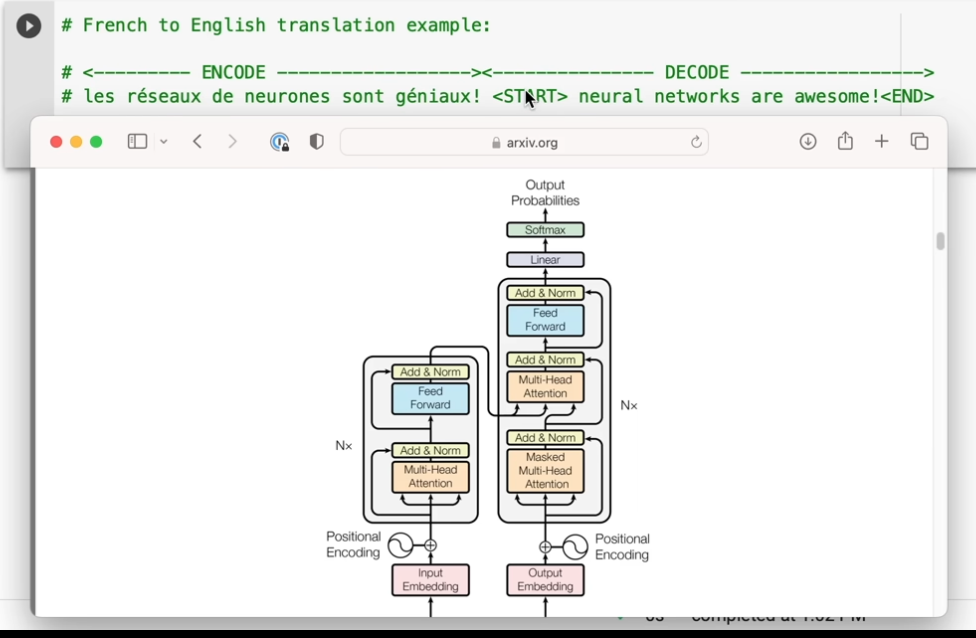

To build ChatGPT from home...

- Pretraining: Train decoder only transformer on large chunk of internet
            - Our used 300,000 tokens with 10 Mil parameters, GPT3 has 175 Bil parameters and trained on 300 bil tokens
            - After pre-training, get a document completer; will babel the internet (unaligned)
- Finetuning: 
            - Will align it to be an assistant
                - Collect training data specific to what an assistant would do
                - Fine tune model specifally to these documents (expect question at top, expect to complete answer); large models are sample efficient in fine tuning
                - Let model respond, have raters rank the response, use that to train a reward model, using a differnt netowrk, to predict how much of any candidate response would be desirable
                - Once have reward model, will run PPO, to finetune this sampling policy, such that answers chatgpt generates is expected to score a high reward according to the reward model
